### Packages Required

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#pip install wordcloud
from wordcloud import WordCloud

import tensorflow as tf
import keras
import re
import nltk
import string
from keras.models import Sequential,Model
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Input,Dense,LSTM,Dropout,Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam,RMSprop

### Datasets

In [2]:
path = 'C:/Users/Nithin/Downloads/Toxic Comments Classification/'
train = pd.read_csv(path + 'Datasets/train.csv')
test = pd.read_csv(path + 'Datasets/test.csv',encoding='latin1')

In [3]:
train.comment_text[1]

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

In [4]:
train.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [5]:
labels = list(train.columns[2:8])

In [6]:
no_of_rows = len(train)
label_pct = dict()
for i in labels:
    label_pct[i] = train[i].sum()/no_of_rows

[Text(0.5, 1.0, 'Toxic comment calsses'),
 Text(0.5, 0, 'Toxicity Class'),
 Text(0, 0.5, 'Percentage')]

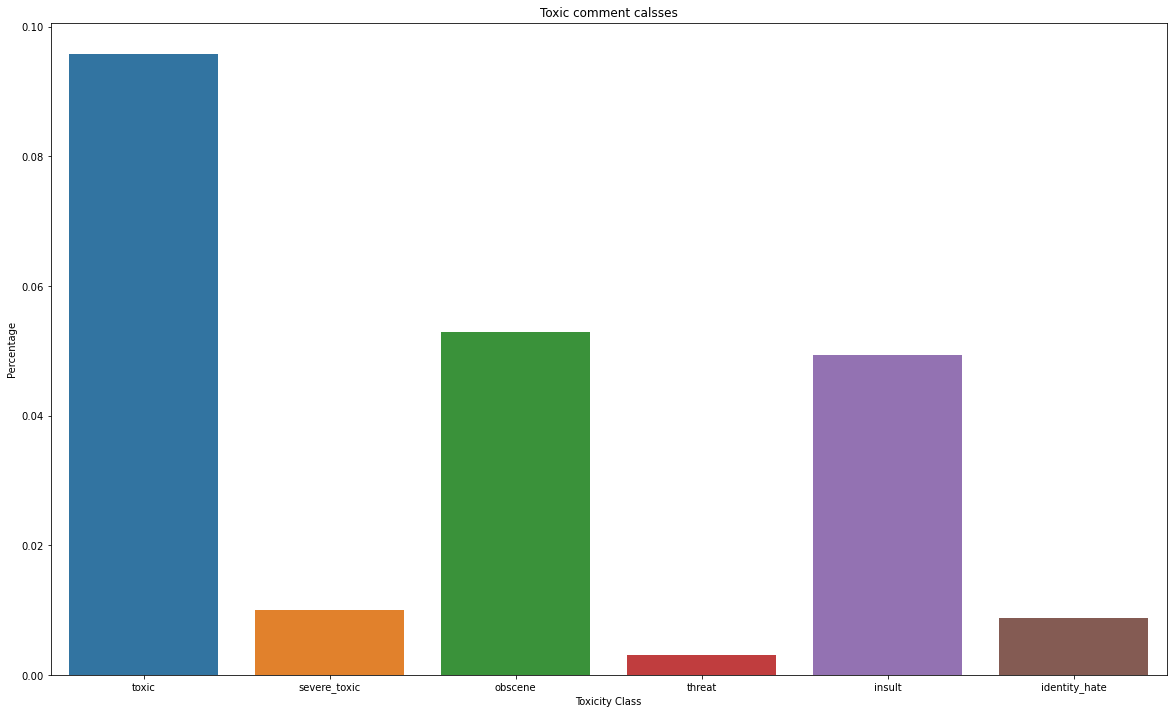

In [7]:
plt.figure(figsize=(20,12))
ax = sns.barplot(x=list(label_pct.keys()),y=list(label_pct.values()))
ax.set(title="Toxic comment calsses",
       xlabel="Toxicity Class",
       ylabel="Percentage")

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nithin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
def clean_comment(comment):   
    comment = comment.lower()  # convert to lowercase
    comment = re.sub(r'^https?:\/\/.*[\s]*', '', comment)  # remove links
    words = nltk.tokenize.word_tokenize(comment)
    lemmatizer = nltk.wordnet.WordNetLemmatizer()
    stop_words = set(nltk.corpus.stopwords.words('english'))
    final_tokens = []
    for w in words:
        w = "".join(["" if c in string.punctuation else c for c in w])  # remove punctutation
        if w != "" and w not in stop_words:  # process only non stopwords
            final_tokens.append(lemmatizer.lemmatize(w))  # using WordNet for lemmatizing
    cleaned_comment = " ".join(final_tokens)
    return cleaned_comment

In [10]:
train['comment'] = train.apply(lambda r: clean_comment(r.comment_text), axis=1)

In [11]:
train.drop('comment_text', inplace=True, axis=1)

In [12]:
test['comment'] = test.apply(lambda r: clean_comment(r.comment_text), axis=1)
test.drop('comment_text', inplace=True, axis=1)

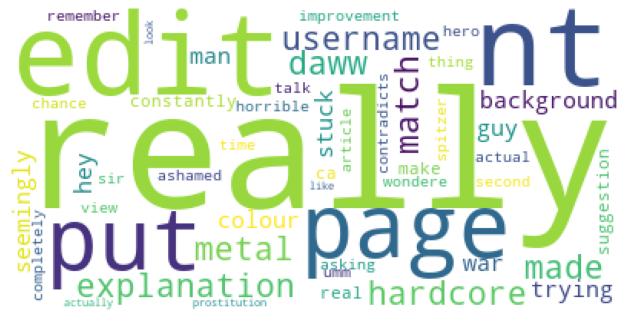

In [13]:
wordcloud = WordCloud(stopwords=nltk.corpus.stopwords.words('english'), 
                      max_words=50, background_color="white").generate(str(train.comment))
plt.figure(figsize=(11,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

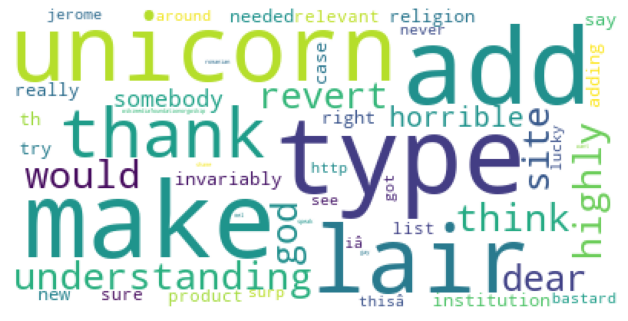

In [14]:
wordcloud = WordCloud(stopwords=nltk.corpus.stopwords.words('english'), 
                      max_words=50, background_color="white").generate(str(test.comment))
plt.figure(figsize=(11,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Model Building

In [15]:
x = list(train.comment)
y = train[labels].values

In [16]:
MAX_LEN = 200 # Maximum number of words in a comment to be used.
NUM_WORDS = 1000 # Number of unique words to be used.
WORD_VEC_SIZE = 100 # Size of each word vector.

In [17]:
train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.2,random_state=1001)

In [18]:
# Fit the tokenizer on the training comments.
tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(train_x)

train_x = tokenizer.texts_to_sequences(train_x)
test_x = tokenizer.texts_to_sequences(test_x)

vocab_size = len(tokenizer.word_index) + 1

# Pad the the training and test sequences so all of them have the same length.
train_x = pad_sequences(train_x, padding='post', maxlen=MAX_LEN)
test_x = pad_sequences(test_x, padding='post', maxlen=MAX_LEN)

In [19]:
M0 = Sequential()
M0.add(Input(shape=MAX_LEN))
M0.add(Embedding(vocab_size, 128, input_length=50))
M0.add(LSTM(512, dropout=0.2,return_sequences=True))
M0.add(LSTM(128, dropout=0.2))
M0.add(Dense(16, activation='relu'))
M0.add(Dense(6, activation='sigmoid'))

M0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          24798208  
                                                                 
 lstm (LSTM)                 (None, 200, 512)          1312768   
                                                                 
 lstm_1 (LSTM)               (None, 128)               328192    
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 26,441,334
Trainable params: 26,441,334
Non-trainable params: 0
_________________________________________________________________


In [20]:
M0.compile(optimizer='Adam', loss='categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
M0.fit(train_x, train_y, epochs=3, batch_size=1000, verbose=1, validation_split=0.2)

  3/103 [..............................] - ETA: 1:09:08 - loss: 0.3886 - accuracy: 0.0010

In [ ]:
M0.save(path + 'Model/Tox_M0.h5')

In [25]:
M0.evaluate(test_x, test_y, verbose=1)

998/998 [==============================] - 514s 515ms/step - loss: 0.4171 - accuracy: 3.1333e-04


[0.41706788539886475, 0.0003133322752546519]

In [ ]:
plt.subplots(figsize=(11,6))
plt.plot(M0['loss'], marker='.', color='b', 
         label= 'train loss')
plt.plot(M0['val_loss'], marker = '+', color = 'g',
         label = 'val loss')
plt.legend()

In [ ]:
plt.subplots(figsize=(11,6))
plt.plot(M0.history['acc'], marker='.', color='b', 
         label= 'train accuracy')
plt.plot(M0.history['val_acc'], marker = '+', color = 'g',
         label = 'val accuracy')
plt.legend()

In [29]:
pred = M0.predict(test_x)
pred

998/998 [==============================] - 485s 486ms/step


array([[5.2494597e-06, 4.3311702e-06, 1.2104417e-05, 2.8426967e-07,
        7.1130189e-06, 1.7201070e-05],
       [5.2494597e-06, 4.3311702e-06, 1.2104417e-05, 2.8426967e-07,
        7.1130189e-06, 1.7201070e-05],
       [5.2494597e-06, 4.3311702e-06, 1.2104417e-05, 2.8426967e-07,
        7.1130189e-06, 1.7201070e-05],
       ...,
       [5.2494597e-06, 4.3311702e-06, 1.2104417e-05, 2.8426967e-07,
        7.1130189e-06, 1.7201070e-05],
       [5.2494597e-06, 4.3311702e-06, 1.2104417e-05, 2.8426967e-07,
        7.1130189e-06, 1.7201070e-05],
       [5.2494597e-06, 4.3311702e-06, 1.2104417e-05, 2.8426967e-07,
        7.1130189e-06, 1.7201068e-05]], dtype=float32)

In [ ]:
final = pd.DataFrame()
columns = ['toxic' ,'severe_toxic' ,'obscene' ,'threat' ,'insult' ,'identity_hate']
final['id'] = test['id']
final[columns] = pred